In [1]:
using Plots
using Distributions
using Random, DataFrames
using LinearAlgebra
using MLJ, MLJLinearModels
include("src/qsrfe.jl")
using .qsrfe

In [5]:
bX, bY = @load_boston
bX = Matrix(DataFrame(bX))
bY = collect(bY)
bX

bX = (bX .- mean(bX)) ./ std(bX)
Y = (bY .- mean(bY)) ./ std(bY)
(xtrain, xtest), (ytrain, ytest) = partition((bX, bY), 0.9, rng=123, multi=true)

(([-0.5038479125622459 -0.3736555203370192 … 2.078229709420622 -0.467825129690138; -0.501959374129676 -0.5073242348197996 … 1.4241218550991361 -0.42919487120461447; … ; -0.49914651653645764 -0.5073242348197996 … 1.9216368104040449 -0.4766472648460015; -0.5064475685558644 -0.5073242348197996 … 2.0837769610716577 -0.4131546254666808], [-0.5053313011212186 -0.5073242348197996 … 2.0157395853999223 -0.4811251667811747; -0.5059181736121553 -0.3736555203370192 … 2.1453314040909777 -0.4749095715577254; … ; -0.20158311583976354 -0.5073242348197996 … 0.08262263654995178 -0.2601707817411386; -0.5037144443508349 -0.3736555203370192 … 2.117929317622008 -0.4432300862253064]), ([48.8, 20.2, 20.9, 13.4, 12.7, 13.6, 22.1, 24.4, 13.3, 20.3  …  29.8, 31.5, 24.8, 35.2, 50.0, 19.4, 18.6, 22.6, 41.3, 20.4], [46.7, 35.1, 23.9, 17.2, 24.1, 23.0, 14.9, 21.7, 38.7, 15.0  …  22.2, 19.8, 31.7, 27.1, 19.5, 24.6, 15.6, 26.4, 7.0, 33.8]))

In [4]:
N_ = range(;start=7,length=8,step=1)
N = map(x -> 2^x,N_)
λ = map(x -> 2.0^(-x),range(5.0,13,step=1.5))

6-element Vector{Float64}:
 0.03125
 0.011048543456039804
 0.00390625
 0.0013810679320049755
 0.00048828125
 0.00017263349150062194

In [9]:
#no quantization
function test_model(N,λ,xtrain,xtest,ytrain,ytest)
    model = qsrfe.srfeRegressor(N=N,λ=λ)
    c, ω, ζ = qsrfe.fit(model,xtrain,ytrain)
    ypred = qsrfe.predict(model,xtest,c, ω, ζ)
    #ytrainpred = qsrfe.predict(model,xtrain,c, ω, ζ)
    return qsrfe.mse(ypred,ytest)#, qsrfe.mse(ytrainpred,ytrain)
end

function test_model(N,λ,xtrain,xtest,ytrain,ytest,quantizer)
    model = qsrfe.srfeRegressor(N=N,λ=λ)
    c, ω, ζ = qsrfe.fit(model,xtrain,ytrain,quantizer)
    ypred = qsrfe.predict(model,xtest,c, ω, ζ, quantizer)
    #ytrainpred = qsrfe.predict(model,xtrain,c, ω, ζ)
    return qsrfe.mse(ypred,ytest)#, qsrfe.mse(ytrainpred,ytrain)
end


test_model (generic function with 2 methods)

In [29]:
optimum = zeros(length(N))
testmse = 0.0
i=1
for n in N
    opt = 100000000.0
    tol = 3
    for l in λ
        print("current iter: ",(n,l)," ")
        testmse = test_model(n,l,xtrain,xtest,ytrain,ytest)
        testmse < opt ? opt = testmse : tol = tol - 1
        if tol == 0
            break
        end
        println("testmse: ",testmse)
    end
    optimum[i] = opt
    i = i+1
end


current iter: (32, 0.25) testmse: 31.23559552061527
current iter: (32, 0.08838834764831843) testmse: 21.409639641721117
current iter: (32, 0.03125) testmse: 27.309468394034276
current iter: (32, 0.011048543456039804) testmse: 22.14090701583186
current iter: (32, 0.00390625) current iter: (64, 0.25) testmse: 29.778538028304563
current iter: (64, 0.08838834764831843) testmse: 25.656618585181487
current iter: (64, 0.03125) testmse: 24.076759886233763
current iter: (64, 0.011048543456039804) testmse: 19.02510319094154
current iter: (64, 0.00390625) testmse: 20.07797329114967
current iter: (64, 0.0013810679320049755) testmse: 18.941556419700717
current iter: (64, 0.00048828125) testmse: 16.676786924360616
current iter: (128, 0.25) testmse: 23.471919991990696
current iter: (128, 0.08838834764831843) testmse: 24.654680195628135
current iter: (128, 0.03125) testmse: 25.57030276065008
current iter: (128, 0.011048543456039804) testmse: 19.52598628731437
current iter: (128, 0.00390625) testmse: 1

In [30]:
optimum

10-element Vector{Float64}:
 21.409639641721117
 16.676786924360616
 14.001605915427623
  8.986406873731056
 10.284715895320085
  9.442321970744826
  7.975838205353225
  9.052489327866793
  9.594882684713491
  9.949130020128203

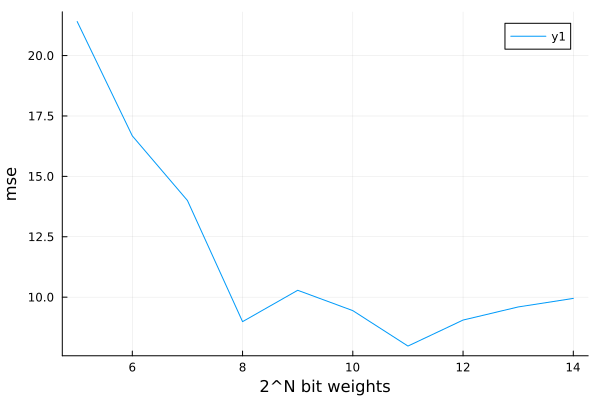

In [36]:
plot(N_,optimum,xlabel="2^N bit weights",ylabel="mse",)

In [10]:
optimumq = zeros(length(N))
testmse = 0.0
i=1
quantizer = ΣΔQ(K=2)
for n in N
    opt = 100000000.0
    tol = 3
    for l in λ
        print("current iter: ",(n,l)," ")
        testmse = test_model(n,l,xtrain,xtest,ytrain,ytest,quantizer)
        testmse < opt ? opt = testmse : tol = tol - 1
        if tol == 0
            break
        end
        println("testmse: ",testmse)
    end
    optimumq[i] = opt
    i = i+1
end

current iter: (128, 0.03125) testmse: 33.69888088724526
current iter: (128, 0.011048543456039804) testmse: 39.83989985573308
current iter: (128, 0.00390625) testmse: 53.39023880427755
current iter: (128, 0.0013810679320049755) current iter: (256, 0.03125) testmse: 50.50790433964687
current iter: (256, 0.011048543456039804) testmse: 55.98917962456615
current iter: (256, 0.00390625) testmse: 75.80359953950202
current iter: (256, 0.0013810679320049755) current iter: (512, 0.03125) testmse: 75.92620696779234
current iter: (512, 0.011048543456039804) testmse: 115.69298511660672
current iter: (512, 0.00390625) testmse: 175.060925780962
current iter: (512, 0.0013810679320049755) current iter: (1024, 0.03125) testmse: 77.22151928839706
current iter: (1024, 0.011048543456039804) testmse: 98.9631672373124
current iter: (1024, 0.00390625) testmse: 116.35097756741321
current iter: (1024, 0.0013810679320049755) current iter: (2048, 0.03125) testmse: 47.57784432408243
current iter: (2048, 0.01104854

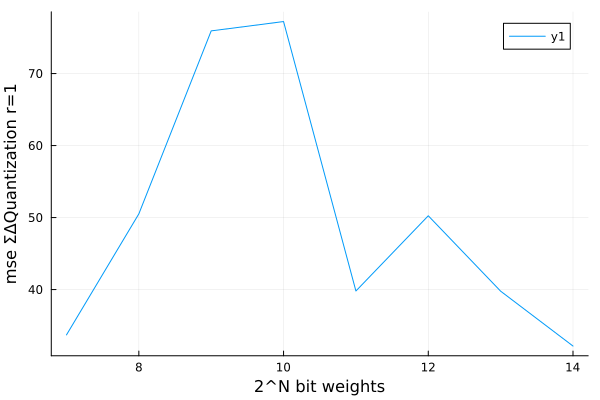

In [11]:
plot(N_,optimumq,xlabel="2^N bit weights",ylabel="mse ΣΔQuantization r=1",)

In [12]:
optimumq2 = zeros(length(N))
testmse = 0.0
i=1
quantizer = ΣΔQ(K=2,λ=2,condense=true)
for n in N
    opt = 100000000.0
    tol = 3
    for l in λ
        print("current iter: ",(n,l)," ")
        testmse = test_model(n,l,xtrain,xtest,ytrain,ytest,quantizer)
        testmse < opt ? opt = testmse : tol = tol - 1
        if tol == 0
            break
        end
        println("testmse: ",testmse)
    end
    optimumq2[i] = opt
    i = i+1
end

current iter: (128, 0.03125) testmse: 45.549825825644916
current iter: (128, 0.011048543456039804) testmse: 53.218310605234464
current iter: (128, 0.00390625) testmse: 44.31757648422538
current iter: (128, 0.0013810679320049755) testmse: 47.123068034230485
current iter: (128, 0.00048828125) testmse: 38.57685930148995
current iter: (128, 0.00017263349150062194) current iter: (256, 0.03125) testmse: 35.21308490741223
current iter: (256, 0.011048543456039804) testmse: 48.241922967701186
current iter: (256, 0.00390625) testmse: 28.83324175924612
current iter: (256, 0.0013810679320049755) testmse: 50.731538335531596
current iter: (256, 0.00048828125) current iter: (512, 0.03125) testmse: 43.611261193818734
current iter: (512, 0.011048543456039804) testmse: 30.92431139383254
current iter: (512, 0.00390625) testmse: 53.561418264099856
current iter: (512, 0.0013810679320049755) testmse: 70.60937996977948
current iter: (512, 0.00048828125) current iter: (1024, 0.03125) testmse: 39.5750631776870

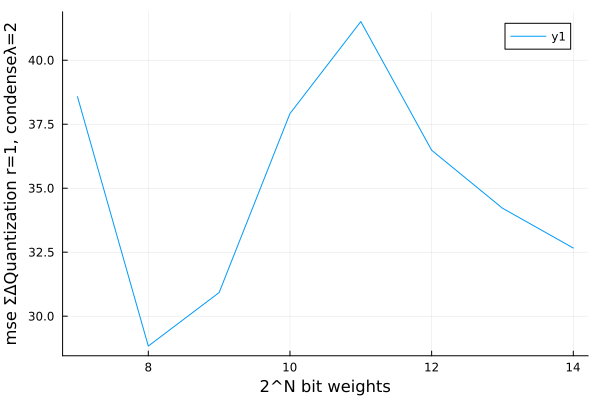

In [15]:
plot(N_,optimumq2,xlabel="2^N bit weights",ylabel="mse ΣΔQuantization r=1, condenseλ=2",)

In [14]:
optimumq3 = zeros(length(N))
testmse = 0.0
i=1
quantizer = ΣΔQ(K=2,λ=4,condense=true)
for n in N
    opt = 100000000.0
    tol = 3
    for l in λ
        print("current iter: ",(n,l)," ")
        testmse = test_model(n,l,xtrain,xtest,ytrain,ytest,quantizer)
        testmse < opt ? opt = testmse : tol = tol - 1
        if tol == 0
            break
        end
        println("testmse: ",testmse)
    end
    optimumq3[i] = opt
    i = i+1
end

current iter: (128, 0.03125) testmse: 37.025035201928425
current iter: (128, 0.011048543456039804) testmse: 47.28956995446117
current iter: (128, 0.00390625) testmse: 34.82315234755313
current iter: (128, 0.0013810679320049755) testmse: 35.803934920911814
current iter: (128, 0.00048828125) current iter: (256, 0.03125) testmse: 40.21173017367968
current iter: (256, 0.011048543456039804) testmse: 34.63698111113509
current iter: (256, 0.00390625) testmse: 39.361345391509595
current iter: (256, 0.0013810679320049755) testmse: 44.183208100810226
current iter: (256, 0.00048828125) current iter: (512, 0.03125) testmse: 36.994084941572524
current iter: (512, 0.011048543456039804) testmse: 38.32621296495832
current iter: (512, 0.00390625) testmse: 58.21509461256036
current iter: (512, 0.0013810679320049755) current iter: (1024, 0.03125) testmse: 36.90037434498882
current iter: (1024, 0.011048543456039804) testmse: 34.409702745311584
current iter: (1024, 0.00390625) testmse: 59.53551753259459
cu

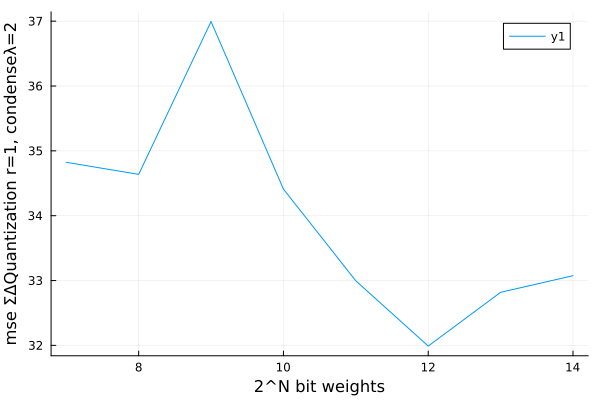

In [16]:
plot(N_,optimumq3,xlabel="2^N bit weights",ylabel="mse ΣΔQuantization r=1, condenseλ=4",)

In [17]:
optimumq4 = zeros(length(N))
testmse = 0.0
i=1
quantizer = ΣΔQ(K=2,λ=8,condense=true)
for n in N
    opt = 100000000.0
    tol = 3
    for l in λ
        print("current iter: ",(n,l)," ")
        testmse = test_model(n,l,xtrain,xtest,ytrain,ytest,quantizer)
        testmse < opt ? opt = testmse : tol = tol - 1
        if tol == 0
            break
        end
        println("testmse: ",testmse)
    end
    optimumq4[i] = opt
    i = i+1
end

current iter: (128, 0.03125) testmse: 42.36294801980196
current iter: (128, 0.011048543456039804) testmse: 39.08126217728077
current iter: (128, 0.00390625) testmse: 46.66202328839357
current iter: (128, 0.0013810679320049755) testmse: 31.581389474433415
current iter: (128, 0.00048828125) testmse: 49.234920340136384
current iter: (128, 0.00017263349150062194) current iter: (256, 0.03125) testmse: 35.90987385848509
current iter: (256, 0.011048543456039804) testmse: 50.26998886039579
current iter: (256, 0.00390625) testmse: 47.84527523446504
current iter: (256, 0.0013810679320049755) current iter: (512, 0.03125) testmse: 28.723664277365106
current iter: (512, 0.011048543456039804) testmse: 33.29339593624233
current iter: (512, 0.00390625) testmse: 47.404764053176535
current iter: (512, 0.0013810679320049755) current iter: (1024, 0.03125) testmse: 31.1283652090735
current iter: (1024, 0.011048543456039804) testmse: 43.374659672243496
current iter: (1024, 0.00390625) testmse: 36.4813806148

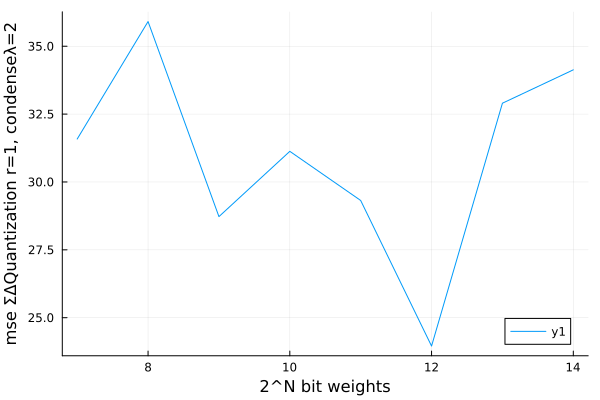

In [18]:
plot(N_,optimumq4,xlabel="2^N bit weights",ylabel="mse ΣΔQuantization r=1, condenseλ=8",)

In [19]:
optimumq5 = zeros(length(N))
testmse = 0.0
i=1
quantizer = ΣΔQ(K=2,λ=16,condense=true)
for n in N
    opt = 100000000.0
    tol = 3
    for l in λ
        print("current iter: ",(n,l)," ")
        testmse = test_model(n,l,xtrain,xtest,ytrain,ytest,quantizer)
        testmse < opt ? opt = testmse : tol = tol - 1
        if tol == 0
            break
        end
        println("testmse: ",testmse)
    end
    optimumq5[i] = opt
    i = i+1
end

current iter: (128, 0.03125) testmse: 71.76459751344353
current iter: (128, 0.011048543456039804) testmse: 156.67427541545194
current iter: (128, 0.00390625) testmse: 42.291944608129924
current iter: (128, 0.0013810679320049755) testmse: 49.33882639594944
current iter: (128, 0.00048828125) testmse: 41.45601268562682
current iter: (128, 0.00017263349150062194) testmse: 39.335424484863196
current iter: (256, 0.03125) testmse: 53.73219824824345
current iter: (256, 0.011048543456039804) testmse: 72.70676670908854
current iter: (256, 0.00390625) testmse: 42.31575275082895
current iter: (256, 0.0013810679320049755) testmse: 47.17839847000814
current iter: (256, 0.00048828125) testmse: 39.41400022682027
current iter: (256, 0.00017263349150062194) current iter: (512, 0.03125) testmse: 45.641828580234346
current iter: (512, 0.011048543456039804) testmse: 40.034614842273754
current iter: (512, 0.00390625) testmse: 38.64001276704596
current iter: (512, 0.0013810679320049755) testmse: 29.977862246

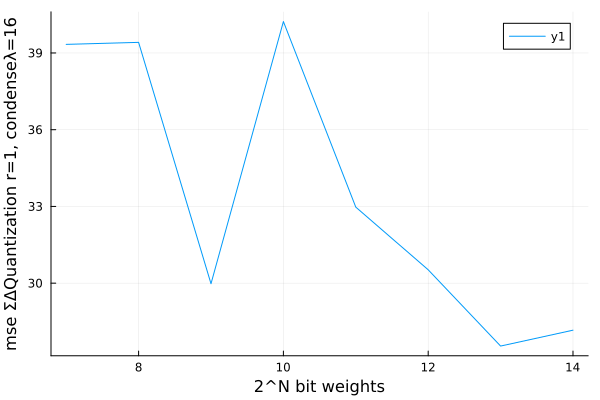

In [20]:
plot(N_,optimumq5,xlabel="2^N bit weights",ylabel="mse ΣΔQuantization r=1, condenseλ=16",)

In [21]:
optimumq6 = zeros(length(N))
testmse = 0.0
i=1
quantizer = βQ(K=2,β=1.1, λ=16,condense=true)
for n in N
    opt = 100000000.0
    tol = 3
    for l in λ
        print("current iter: ",(n,l)," ")
        testmse = test_model(n,l,xtrain,xtest,ytrain,ytest,quantizer)
        testmse < opt ? opt = testmse : tol = tol - 1
        if tol == 0
            break
        end
        println("testmse: ",testmse)
    end
    optimumq6[i] = opt
    i = i+1
end

current iter: (128, 0.03125) testmse: 38.484040904477354
current iter: (128, 0.011048543456039804) testmse: 81.86903711026606
current iter: (128, 0.00390625) testmse: 42.12624085561827
current iter: (128, 0.0013810679320049755) current iter: (256, 0.03125) testmse: 33.91547369488779
current iter: (256, 0.011048543456039804) testmse: 38.009430805857924
current iter: (256, 0.00390625) testmse: 46.66884013483684
current iter: (256, 0.0013810679320049755) current iter: (512, 0.03125) testmse: 31.046850998567802
current iter: (512, 0.011048543456039804) testmse: 31.655434624009754
current iter: (512, 0.00390625) testmse: 28.78571803939361
current iter: (512, 0.0013810679320049755) testmse: 30.58307081910561
current iter: (512, 0.00048828125) testmse: 25.737735695588803
current iter: (512, 0.00017263349150062194) current iter: (1024, 0.03125) testmse: 27.567593917895646
current iter: (1024, 0.011048543456039804) testmse: 24.879064467853127
current iter: (1024, 0.00390625) testmse: 33.5490555

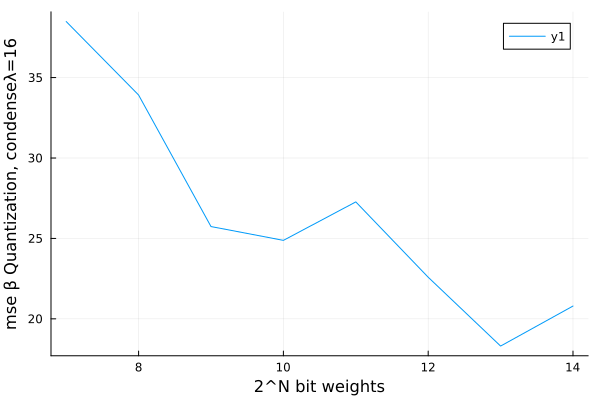

In [23]:
plot(N_,optimumq6,xlabel="2^N bit weights",ylabel="mse β Quantization, condenseλ=16",)

In [24]:
optimumq7 = zeros(length(N))
testmse = 0.0
i=1
quantizer = βQ(K=2,β=1.2, λ=32,condense=true)
for n in [2^14,2^15,2^16]
    opt = 100000000.0
    tol = 3
    for l in 0.002:0.0005:0.004
        print("current iter: ",(n,l)," ")
        testmse = test_model(n,l,xtrain,xtest,ytrain,ytest,quantizer)
        testmse < opt ? opt = testmse : tol = tol - 1
        if tol == 0
            break
        end
        println("testmse: ",testmse)
    end
    optimumq7[i] = opt
    i = i+1
end

current iter: (16384, 0.002) testmse: 22.72644106706074
current iter: (16384, 0.0025) testmse: 24.03126464447151
current iter: (16384, 0.003) testmse: 20.8240748274404
current iter: (16384, 0.0035) testmse: 20.763477165516022
current iter: (16384, 0.004) testmse: 24.858956518350872
current iter: (32768, 0.002) testmse: 20.199606644661024
current iter: (32768, 0.0025) testmse: 21.40901828787852
current iter: (32768, 0.003) testmse: 21.56540615144757
current iter: (32768, 0.0035) current iter: (65536, 0.002) 

LoadError: OutOfMemoryError()